In [1]:
!nvidia-smi

Thu Aug 15 20:33:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install ultralytics
from IPython import display
display.clear_output()


In [3]:
!cp -r /content/drive/MyDrive/Models/ppe_detection /content/


In [4]:
!cp -r /content/drive/MyDrive/Models/weights /content/


In [5]:
from ultralytics import YOLO
from IPython.display import Image, display

In [8]:
import os
import cv2
from ultralytics import YOLO

# Load person detection model
person_model = YOLO('/content/weights/PersonDetection.pt')  # Adjust this path if necessary
#convert.py

# Paths (hardcoded for Google Colab)
input_image_dir = '/content/ppe_detection/images'  # Path to original images
input_label_dir = '/content/ppe_detection/labels'  # Path to PascalVOC annotations
output_image_dir = '/content/PpeDetection/images'  # Directory to save cropped images
output_label_dir = '/content/PpeDetection/labels'  # Directory to save corresponding labels
classes_file = '/content/classes.txt'  # Path to classes.txt file

def parse_yolo_annotation(label_file):
    objects = []
    with open(label_file, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            objects.append((class_id, x_center, y_center, width, height))
    return objects

def convert_yolo_bbox_to_coords(bbox, img_width, img_height):
    class_id, x_center, y_center, width, height = bbox
    xmin = int((x_center - width / 2) * img_width)
    ymin = int((y_center - height / 2) * img_height)
    xmax = int((x_center + width / 2) * img_width)
    ymax = int((y_center + height / 2) * img_height)
    return class_id, xmin, ymin, xmax, ymax

def save_cropped_image_and_label(image, objects, crop_coords, output_image_dir, output_label_dir, base_filename, index):
    xmin_crop, ymin_crop, xmax_crop, ymax_crop = crop_coords

    # Crop the image
    cropped_image = image[ymin_crop:ymax_crop, xmin_crop:xmax_crop]
    cropped_image_filename = f"{base_filename}_crop{index}.jpg"
    cv2.imwrite(os.path.join(output_image_dir, cropped_image_filename), cropped_image)

    # Update annotations for the cropped image
    updated_labels = []
    img_width = xmax_crop - xmin_crop
    img_height = ymax_crop - ymin_crop

    for obj in objects:
        class_id, xmin, ymin, xmax, ymax = convert_yolo_bbox_to_coords(obj, image.shape[1], image.shape[0])

        # Check if the object is within the crop
        if xmin < xmax_crop and ymin < ymax_crop and xmax > xmin_crop and ymax > ymin_crop:
            # Clip bbox to the cropped image boundaries
            xmin_clipped = max(xmin, xmin_crop) - xmin_crop
            ymin_clipped = max(ymin, ymin_crop) - ymin_crop
            xmax_clipped = min(xmax, xmax_crop) - xmin_crop
            ymax_clipped = min(ymax, ymax_crop) - ymin_crop

            # Convert to YOLO format (normalized coordinates)
            x_center = (xmin_clipped + xmax_clipped) / 2.0 / img_width
            y_center = (ymin_clipped + ymax_clipped) / 2.0 / img_height
            width = (xmax_clipped - xmin_clipped) / img_width
            height = (ymax_clipped - ymin_clipped) / img_height

            updated_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Save the updated label file
    label_filename = f"{base_filename}_crop{index}.txt"
    with open(os.path.join(output_label_dir, label_filename), 'w') as f:
        for label in updated_labels:
            f.write(label + '\n')

def process_images(input_image_dir, input_label_dir, output_image_dir, output_label_dir):
    if not os.path.exists(output_image_dir):
        os.makedirs(output_image_dir)
    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)

    for filename in os.listdir(input_image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(input_image_dir, filename)
            label_path = os.path.join(input_label_dir, filename.replace('.jpg', '.txt'))

            # Load image and annotations
            image = cv2.imread(image_path)
            objects = parse_yolo_annotation(label_path)

            # Run person detection model to get person bounding boxes
            results = person_model(image)
            person_bboxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

            # Save cropped images and corresponding labels
            for index, person_bbox in enumerate(person_bboxes):
                xmin, ymin, xmax, ymax = person_bbox
                crop_coords = (xmin, ymin, xmax, ymax)

                save_cropped_image_and_label(image, objects, crop_coords, output_image_dir, output_label_dir, filename.split('.')[0], index)

# Load classes.txt and create class-to-index mapping
with open(classes_file, 'r') as f:
    classes = f.read().strip().split()
class_to_index = {cls_name: idx for idx, cls_name in enumerate(classes)}

# Run the processing function
process_images(input_image_dir, input_label_dir, output_image_dir, output_label_dir)



0: 640x480 1 person, 15.5ms
Speed: 3.3ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 person, 11.9ms
Speed: 3.0ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

0: 448x640 7 persons, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 12.6ms
Speed: 2.6ms preprocess, 12.6ms inference, 5.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 15.6ms
Speed: 2.9ms preprocess, 15.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 5 persons, 11.3ms
Speed: 3.2ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 544x640 6 persons, 12.3ms
Speed: 6.7ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 448x640 3 persons, 10.0ms
Speed: 2.4ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1,

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

#split.py

def split_dataset(input_dir, output_dir, test_size=0.2, valid_size=0.2):
    images_dir = os.path.join(input_dir, 'images')
    labels_dir = os.path.join(input_dir, 'labels')

    # Create output directories
    os.makedirs(os.path.join(output_dir, 'train/images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'train/labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'valid/images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'valid/labels'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test/images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test/labels'), exist_ok=True)

    # Get list of image files
    image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
    image_files.sort()

    # Split the dataset
    train_files, temp_files = train_test_split(image_files, test_size=test_size, random_state=42)
    valid_files, test_files = train_test_split(temp_files, test_size=test_size / (test_size + valid_size), random_state=42)

    def copy_files(file_list, destination_folder):
        for file in file_list:
            # Copy images
            shutil.copy(os.path.join(images_dir, file), os.path.join(destination_folder, 'images', file))
            # Copy corresponding annotations
            label_file = os.path.splitext(file)[0] + '.txt'
            label_file_path = os.path.join(labels_dir, label_file)
            if os.path.exists(label_file_path):
                shutil.copy(label_file_path, os.path.join(destination_folder, 'labels', label_file))
            else:
                print(f"Warning: Label file {label_file} not found for {file}")

    # Copy files to respective folders
    copy_files(train_files, os.path.join(output_dir, 'train'))
    copy_files(valid_files, os.path.join(output_dir, 'valid'))
    copy_files(test_files, os.path.join(output_dir, 'test'))

# Hardcoded paths for Google Colab
input_dir = '/content/PpeDetection'  # Adjust this path as necessary
output_dir = '/content/outputDataset1'  # Adjust this path as necessary

# Run the dataset split
split_dataset(input_dir, output_dir, test_size=0.2, valid_size=0.2)


In [10]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/outputDataset1/data.yaml epochs=130 imgsz=640

100% 6.25M/6.25M [00:00<00:00, 111MB/s]
Ultralytics YOLOv8.2.78 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/outputDataset1/data.yaml, epochs=130, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

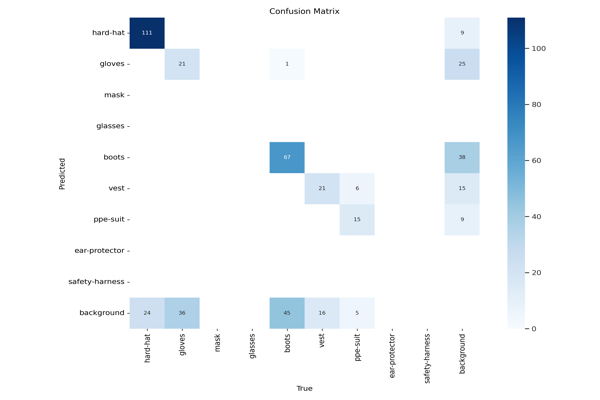

In [13]:
Image.open(f'/content/runs/detect/train/confusion_matrix.png').resize((600,400))

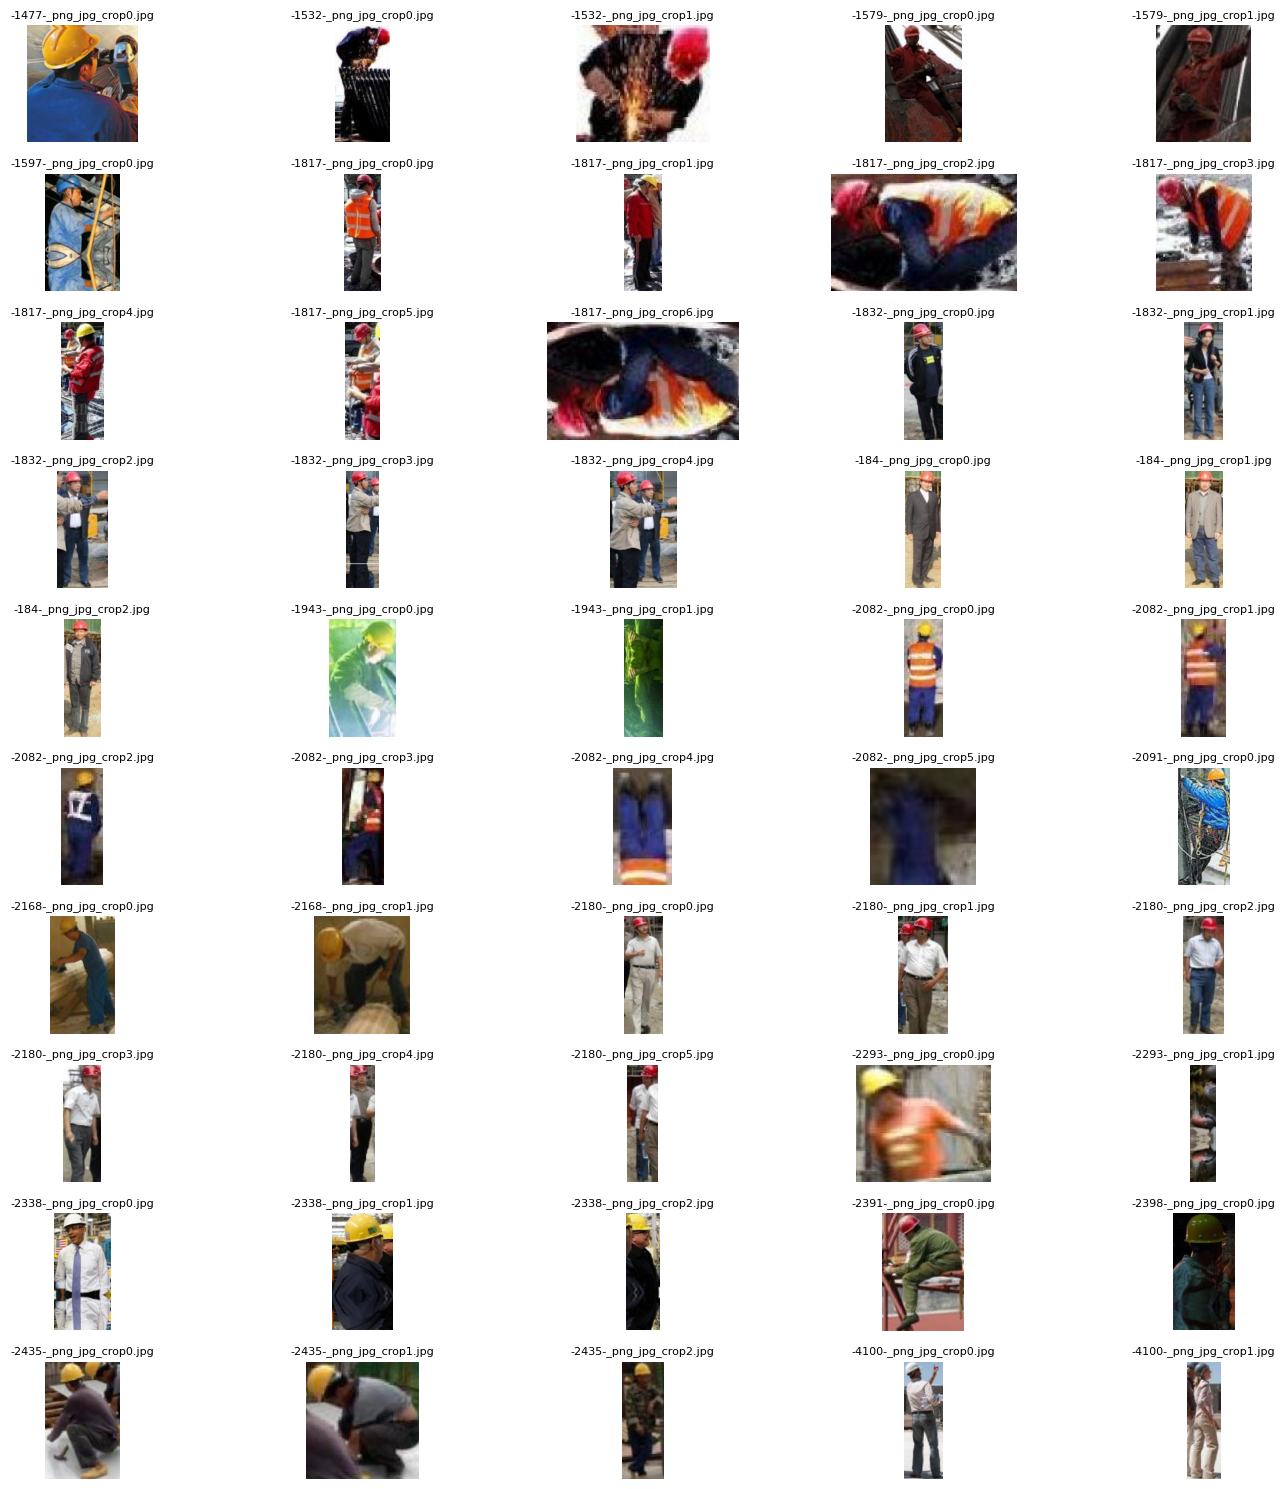

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the images directory
images_dir = '/content/PpeDetection/images'  # Adjust this path as necessary

# List all files in the images directory
image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
image_files.sort()

# Select only the first 50 image files
image_files = image_files[:50]

# Set up the grid size for displaying images
n_cols = 5
n_rows = (len(image_files) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 15))

for i, image_file in enumerate(image_files):
    # Load image
    img_path = os.path.join(images_dir, image_file)
    img = Image.open(img_path)

    # Add subplot
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_file, fontsize=8)

plt.tight_layout()
plt.show()



0: 640x640 3 persons, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Displaying cropped image for whole_image.jpg


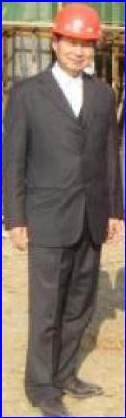


0: 640x224 1 hard-hat, 2 bootss, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 224)
Displaying cropped image for whole_image.jpg


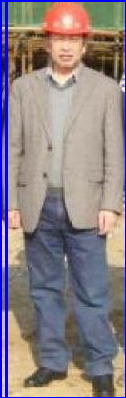


0: 640x224 1 hard-hat, 2 bootss, 10.5ms
Speed: 1.6ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 224)
Displaying cropped image for whole_image.jpg


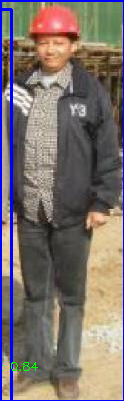


0: 640x224 1 hard-hat, 2 bootss, 10.1ms
Speed: 1.4ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 224)
Displaying final image with PPE detection for whole_image.jpg


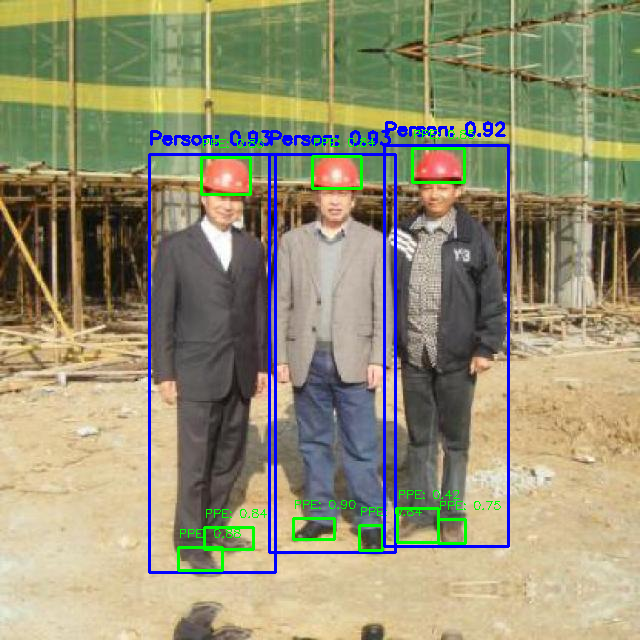

In [16]:
import cv2
import os
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

#inference.py 

def inference(input_dir, output_dir, person_model_path, ppe_model_path):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load models
    person_model = YOLO(person_model_path)
    ppe_model = YOLO(ppe_model_path)

    for image_file in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image_file)
        image = cv2.imread(image_path)

        # Detect persons
        person_results = person_model(image)

        for i, person_bbox in enumerate(person_results[0].boxes):
            xmin, ymin, xmax, ymax = person_bbox.xyxy[0].tolist()
            confidence = person_bbox.conf[0]  # Get confidence for person detection

            # Draw bounding box and confidence score for person
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
            cv2.putText(image, f'Person: {confidence:.2f}',
                        (int(xmin), int(ymin) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (255, 0, 0),
                        2)

            cropped_img = image[int(ymin):int(ymax), int(xmin):int(xmax)]

            # Show cropped image
            print(f"Displaying cropped image for {image_file}")
            cv2_imshow(cropped_img)

            # Detect PPE on cropped image
            ppe_results = ppe_model(cropped_img)

            # Adjust bounding boxes back to full image coordinates
            for ppe_bbox in ppe_results[0].boxes:
                pxmin, pymin, pxmax, pymax = ppe_bbox.xyxy[0].tolist()
                ppe_conf = ppe_bbox.conf[0]  # Get confidence for PPE detection

                # Draw bounding box and confidence score for PPE
                cv2.rectangle(image,
                              (int(xmin + pxmin), int(ymin + pymin)),
                              (int(xmin + pxmax), int(ymin + pymax)),
                              (0, 255, 0), 2)
                cv2.putText(image, f'PPE: {ppe_conf:.2f}',
                            (int(xmin + pxmin), int(ymin + pymin) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.4,
                            (0, 255, 0),
                            1)

        # Show final image with person and PPE detection
        print(f"Displaying final image with PPE detection for {image_file}")
        cv2_imshow(image)

        output_image_path = os.path.join(output_dir, image_file)
        cv2.imwrite(output_image_path, image)

# Hardcoded paths for Google Colab
input_dir = '/content/input_images'  # Change this as necessary
output_dir = '/content/output_images'  # Change this as necessary
person_model_path = '/content/weights/PersonDetection.pt'  # Path to the person detection model
ppe_model_path = '/content/runs/detect/train/weights/best.pt'  # Path to the PPE detection model

# Run inference
inference(input_dir, output_dir, person_model_path, ppe_model_path)
